In [1]:
#Notebook 06- Grad-CAM (Gradient-weighted Class Activation Mapping)
#A deep learning tech. that creates heatmaps to show which parts of an image a CNN focuses on for a specific prediction, making the model more transparent and interpretable.
#Cell 01- Imports
!pip install -q timm==0.9.2  #already used elsewhere; ensures timm available
import os, glob, json, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import timm
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive',force_remount=False)
#device
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00
Mounted at /content/drive
Device: cuda


In [3]:
#Cell 2- config and paths
ROOT="/content/drive/MyDrive/food-10/food-10"
CKPT=os.path.join(ROOT, "outputs_experiments", "best_resnet101_full.pth")  #the best checkpoint
OUT_DIR="/content/gradcam_outputs"
DRIVE_OUT_DIR=os.path.join(ROOT,"gradcam_outputs")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(DRIVE_OUT_DIR, exist_ok=True)

IMG_SIZE=224
BATCH=8      #for batch visualizations if needed
print("CKPT exists?",os.path.exists(CKPT))

CKPT exists? True


In [4]:
#Cell 3- rebuilding df_all, test_df and load class->label mapping
CSV_DIR=os.path.join(ROOT, "prepared_splits")
train_csv=os.path.join(CSV_DIR, "train.csv")
if not os.path.exists(train_csv):
    raise FileNotFoundError("train.csv missing. Run Notebook 01 first.")

train_map=pd.read_csv(train_csv)
cls2idx=dict(zip(train_map['class'], train_map['label']))
idx2class=[None]*(max(cls2idx.values())+1)
for k,v in cls2idx.items(): idx2class[int(v)]=k

#build df_all and test_df
def build_df_all(images_root):
    rows=[]
    for cls in sorted(os.listdir(images_root)):
        cls_dir=os.path.join(images_root,cls)
        if not os.path.isdir(cls_dir): continue
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                rows.append({"path": f"{cls}/{fname}", "class": cls, "fullpath": os.path.join(cls_dir, fname)})
    df_all=pd.DataFrame(rows)
    df_all['no_ext']=df_all['class']+"/"+df_all['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    return df_all

df_all=build_df_all(os.path.join(ROOT,"images"))
#build test_df robustly from test.txt
test_txt=os.path.join(ROOT,"test.txt")
with open(test_txt,'r') as f: tlines=[l.strip() for l in f if l.strip()]
matched=[]; missing=[]
for e in tlines:
    if e in df_all['path'].values:
        matched.append(df_all[df_all['path']==e].iloc[0])
    elif e in df_all['no_ext'].values:
        matched.append(df_all[df_all['no_ext']==e].iloc[0])
    else:
        base=os.path.basename(e).split('.')[0]
        cand=df_all[df_all['path'].str.contains(base)]
        if len(cand)==1:
            matched.append(cand.iloc[0])
        else:
            missing.append(e)
if missing:
    print("Warning: some test entries failed to match (sample):",missing[:10])
test_df=pd.DataFrame(matched).reset_index(drop=True)
print("Test rows:",len(test_df))
print("Classes:",idx2class)

Test rows: 2500
Classes: ['cannoli', 'ceviche', 'crab_cakes', 'frozen_yogurt', 'gnocchi', 'grilled_cheese_sandwich', 'onion_rings', 'pork_chop', 'ravioli', 'spaghetti_bolognese']


In [5]:
#Cell 4- load model from checkpoint (timm resnet101)
num_classes=len(idx2class)
model=timm.create_model("resnet101",pretrained=False,num_classes=num_classes)
ckpt=torch.load(CKPT, map_location='cpu')
#ckpt may have 'model_state' key
state=ckpt.get('model_state',ckpt) if isinstance(ckpt, dict) else ckpt
model.load_state_dict(state)
model=model.to(DEVICE).eval()
print("Model loaded. Num classes:",num_classes)

Model loaded. Num classes: 10


In [ ]:
#Cell 5: Grad-CAM implementation (hooks)
#This implementation attaches to a target conv layer (layer4) and computes Grad-CAM
class GradCAM:
    def __init__(self,model,target_layer):
        self.model=model
        self.device=next(model.parameters()).device
        self.activations=None
        self.gradients=None
        #register forward hook on target_layer to get activations
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        #out shape: (N, C, H, W)
        self.activations=out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        #grad_out is a tuple; use grad_out[0]
        self.gradients=grad_out[0].detach()

    def generate(self,input_tensor,class_idx=None):
        """
        input_tensor: torch.Tensor shape (1,C,H,W) on device
        class_idx: target class index. If None, uses predicted class.
        returns: heatmap (H, W) normalized 0..1
        """
        self.model.zero_grad()
        self.activations=None
        self.gradients=None

        out=self.model(input_tensor)
        if class_idx is None:
            class_idx=int(out.argmax(dim=1).item())
        score=out[:,class_idx]
        score.backward(retain_graph=False)

        #gradients= (1, C, H, W) and activations= (1, C, H, W)
        grads=self.gradients  #(1,C,h,w)
        acts=self.activations  #(1,C,h,w)
        #global average pool gradients->weights
        weights=grads.mean(dim=(2,3),keepdim=True)  #(1,C,1,1)
        #weighted combination
        cam=(weights*acts).sum(dim=1,keepdim=True)  #(1,1,H,W)
        cam=F.relu(cam)
        cam=cam.squeeze(0).squeeze(0).cpu().numpy()  #(H,W)
        #normalize
        cam=(cam-cam.min())/(cam.max()-cam.min()+1e-8)
        return cam

In [ ]:
#Cell 6: transforms and GradCAM instance
val_tf=transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])
#pick target layer: last block of layer4 (use whole layer4)
target_layer=model.layer4  #we register on the entire layer group
gradcam=GradCAM(model, target_layer)
print("GradCAM attached to:", target_layer)

GradCAM attached to: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_block): Identity()
    (act2): ReLU(inplace=True)
    (aa): Identity()
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1),

In [ ]:
#Cell 7- visualization helpers (overlay heatmap)
import cv2  #opencv might be available. If it is not, we can use PIL + numpy
!pip install -q opencv-python-headless
import cv2

def show_img(img, title=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(img)
    plt.show()

def overlay_cam_on_image(img_pil, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    img_pil: PIL.Image (RGB)
    heatmap: numpy array HxW (0..1)
    returns: PIL.Image overlayed
    """
    img=np.array(img_pil.convert("RGB"))
    hmap=(heatmap*255).astype(np.uint8)
    hmap=cv2.resize(hmap,(img.shape[1],img.shape[0]))
    hmap_color=cv2.applyColorMap(hmap,colormap)  #BGR
    hmap_color=cv2.cvtColor(hmap_color,cv2.COLOR_BGR2RGB)
    overlay=(img*(1.0-alpha)+hmap_color*alpha).astype(np.uint8)
    return Image.fromarray(overlay)

Image: /content/drive/MyDrive/food-10/food-10/images/ravioli/100904.jpg


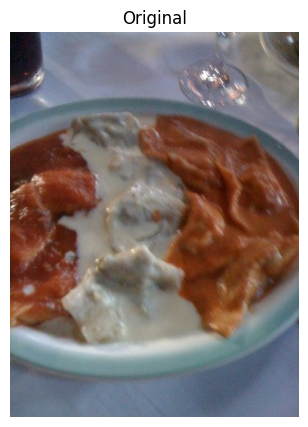

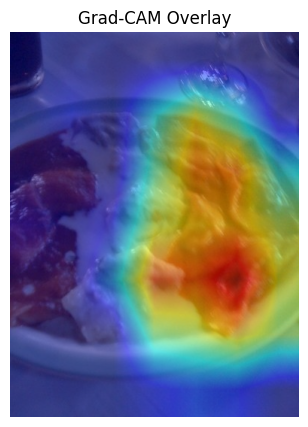

Saved overlay to /content/gradcam_outputs/gradcam_ravioli_100904.jpg and copied to Drive: /content/drive/MyDrive/food-10/food-10/gradcam_outputs/gradcam_ravioli_100904.jpg


In [ ]:
#Cell 8- running grad-CAM on a single image
#we choose an image path from test_df (For an example, the first image of class 'ravioli')
sample_row=test_df[test_df['class'] == 'ravioli'].iloc[0]  #we can change the class name if we want
img_path=sample_row['fullpath']
print("Image:",img_path)
orig=Image.open(img_path).convert("RGB")
inp=val_tf(orig).unsqueeze(0).to(DEVICE)
#generating a heatmap for the predicted class (None->predicted)
heatmap=gradcam.generate(inp,class_idx=None)
overlay=overlay_cam_on_image(orig,heatmap,alpha=0.5)
#showing and then saving
show_img(orig,title="Original")
show_img(overlay,title="Grad-CAM Overlay")
savepath=os.path.join(OUT_DIR,f"gradcam_{sample_row['class']}_{os.path.basename(img_path)}")
overlay.save(savepath)
shutil.copy(savepath,os.path.join(DRIVE_OUT_DIR,os.path.basename(savepath)))
print("Saved overlay to",savepath,"and copied to Drive:",os.path.join(DRIVE_OUT_DIR,os.path.basename(savepath)))

In [ ]:
#Cell 9- We shall generate & save one Grad-CAM example per class (fast)
random.seed(42)
per_class_samples=[]
for cls in idx2class:
    cands=test_df[test_df['class']==cls]
    if len(cands)==0: continue
    #pick random sample (or choose first)
    row=cands.sample(1, random_state=42).iloc[0]
    per_class_samples.append(row)

for row in per_class_samples:
    img_path=row['fullpath']
    orig=Image.open(img_path).convert("RGB")
    inp=val_tf(orig).unsqueeze(0).to(DEVICE)
    heatmap=gradcam.generate(inp, class_idx=None)
    overlay=overlay_cam_on_image(orig, heatmap, alpha=0.5)
    fname=f"gradcam_{row['class']}_{os.path.basename(img_path)}"
    savepath=os.path.join(OUT_DIR, fname)
    overlay.save(savepath)
    shutil.copy(savepath, os.path.join(DRIVE_OUT_DIR, fname))
    print("Saved:",fname)
print("All class overlays saved to",OUT_DIR,"and copied to Drive folder:",DRIVE_OUT_DIR)

Saved: gradcam_cannoli_2985044.jpg
Saved: gradcam_ceviche_3343795.jpg
Saved: gradcam_crab_cakes_2961287.jpg
Saved: gradcam_frozen_yogurt_2874189.jpg
Saved: gradcam_gnocchi_3332468.jpg
Saved: gradcam_grilled_cheese_sandwich_3021628.jpg
Saved: gradcam_onion_rings_2901690.jpg
Saved: gradcam_pork_chop_2899230.jpg
Saved: gradcam_ravioli_3133848.jpg
Saved: gradcam_spaghetti_bolognese_3007698.jpg
All class overlays saved to /content/gradcam_outputs and copied to Drive folder: /content/drive/MyDrive/food-10/food-10/gradcam_outputs


Target names (ordered): ['cannoli', 'ceviche', 'crab_cakes', 'frozen_yogurt', 'gnocchi', 'grilled_cheese_sandwich', 'onion_rings', 'pork_chop', 'ravioli', 'spaghetti_bolognese']
Num classes: 10
Picked 10 samples for visualization
Saved overlays to /content/gradcam_outputs


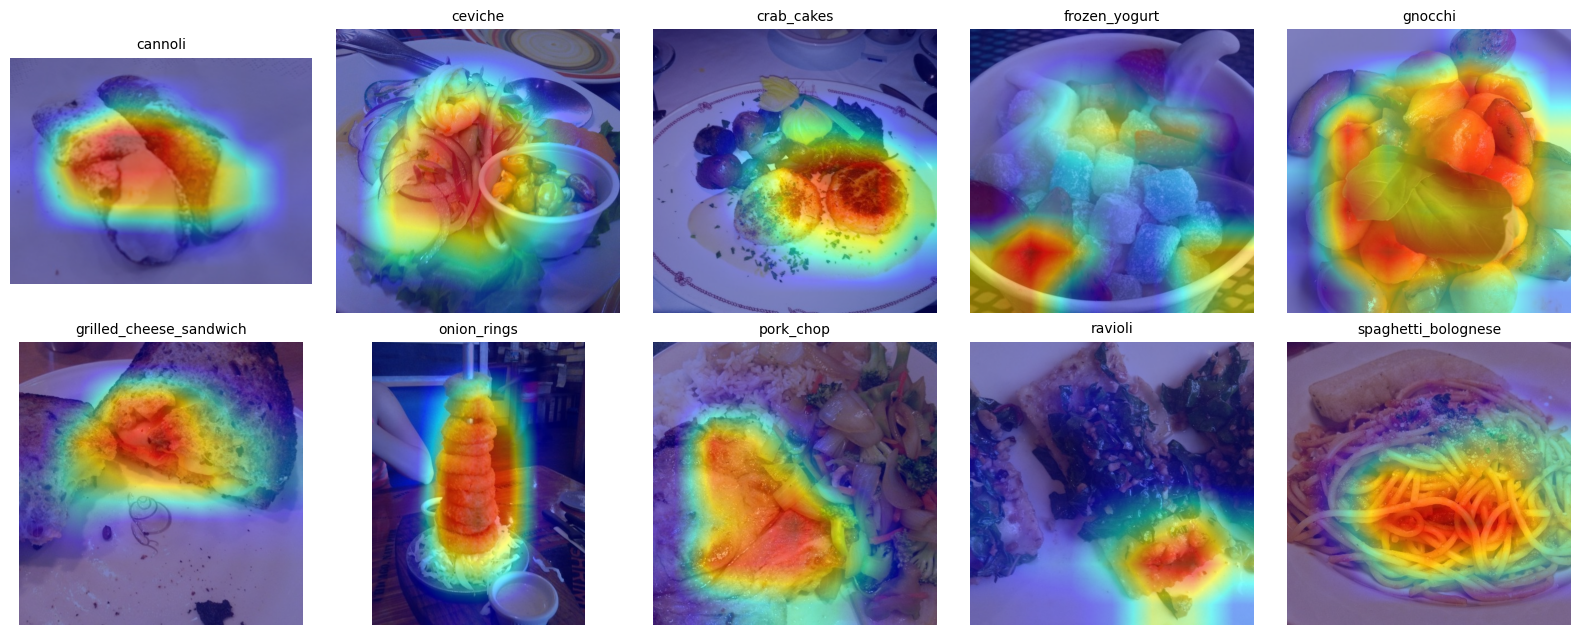

Saved grid to: /content/gradcam_outputs/gradcam_per_class_grid.png


In [ ]:
#Robust per-class Grad-CAM grid (we'll keep exactly one image per class)
import math, os, shutil
import matplotlib.pyplot as plt
from PIL import Image
#1) building an ordered class list from train.csv
train_csv="/content/drive/MyDrive/food-10/food-10/prepared_splits/train.csv"
train_map=pd.read_csv(train_csv)
cls2idx=dict(zip(train_map['class'],train_map['label']))
target_names=[c for c,_ in sorted(cls2idx.items(),key=lambda kv: kv[1])]
num_classes=len(target_names)
print("Target names (ordered):",target_names)
print("Num classes:",num_classes)

#2) picking just one sample per class from 'test_df'
per_class_samples=[]
for cls in target_names:
    cands=test_df[test_df['class']==cls]
    if len(cands) == 0:
        print("Warning: no test samples for class",cls)
        continue
    #deterministic pick
    row=cands.sample(1,random_state=42).iloc[0]
    per_class_samples.append(row)
print("Picked",len(per_class_samples),"samples for visualization")

#3) generating the overlays and keeping them for plotting
overlays=[]
titles=[]
for row in per_class_samples:
    img_path=row['fullpath']
    orig=Image.open(img_path).convert('RGB')
    inp=val_tf(orig).unsqueeze(0).to(DEVICE)   #'val_tf' will have to be defined earlier
    #In case our gradcam API expects class_idx, we can pass 'None' to get the strongest activation
    heatmap=gradcam.generate(inp,class_idx=None)
    overlay_img=overlay_cam_on_image(orig,heatmap,alpha=0.5)  #uses your helper
    overlays.append(overlay_img)
    titles.append(row['class'])
    #saving to disk+copying to Drive
    fname=f"gradcam_{row['class']}_{os.path.basename(img_path)}"
    savepath=os.path.join(OUT_DIR, fname)
    overlay_img.save(savepath)
    try:
        shutil.copy(savepath, os.path.join(DRIVE_OUT_DIR,fname))
    except Exception:
        pass
print("Saved overlays to",OUT_DIR)

# 4)Plotting a neat grid
cols=5  #choosing the number of columns (I have kept 5x2 since it looks good)
rows=math.ceil(num_classes/cols)
fig,axes=plt.subplots(rows,cols,figsize=(cols*3.2,rows*3.2))
axes=axes.flatten()
for i in range(rows*cols):
    ax=axes[i]
    ax.axis('off')
    if i<len(overlays):
        ax.imshow(overlays[i])
        ax.set_title(titles[i],fontsize=10)
plt.tight_layout()
outfig=os.path.join(OUT_DIR,"gradcam_per_class_grid.png")
plt.savefig(outfig,dpi=200,bbox_inches='tight')
plt.show()
print("Saved grid to:",outfig)

In [7]:
#Robust Export Cell
import torch, os, json
import timm
from torchvision import transforms
from PIL import Image
EXPORT_DIR="/content/drive/MyDrive/food-10/food-10/export"
os.makedirs(EXPORT_DIR,exist_ok=True)
print("Exporting to:",EXPORT_DIR)
#Loading checkpoint, robustly
ckpt=torch.load(CKPT,map_location="cpu")
#checkpoint may be a dict with 'model_state' or directly a state_dict
state=ckpt.get("model_state",ckpt) if isinstance(ckpt,dict) else ckpt

#Trying to read model_name from cfg if present, otherwise fallback to resnet101
model_name=None
if isinstance(ckpt,dict):
    cfg=ckpt.get("cfg",{}) or {}
    model_name=cfg.get("model_name",None)

if model_name is None:
    #fallback, using the model we trained (resnet101). We can change to a different model as well, if we want
    print("Warning: model_name not found in checkpoint cfg. Falling back to 'resnet101'.")
    model_name="resnet101"

#infering num_classes from fc weight shape in state dict
fc_w=None
for k,v in state.items():
    if k.endswith("fc.weight") or ".fc.weight" in k:
        fc_w=v
        break
if fc_w is None:
    #as a last resort, trying any 2D weight that looks like classifier
    for k,v in state.items():
        if isinstance(v,torch.Tensor) and v.ndim==2:
            fc_w=v
            break
if fc_w is None:
    raise RuntimeError("Could not infer fc weight from checkpoint state dict. Inspect checkpoint keys.")

num_classes=int(fc_w.shape[0])
print("Inferred num_classes from checkpoint:",num_classes)
print("Using model_name:",model_name)

#build model and load weights
model=timm.create_model(model_name,pretrained=False,num_classes=num_classes)
model.load_state_dict(state)
model.eval()

#Save TorchScript via tracing (CPU is fine)
example=torch.randn(1, 3, 224, 224)
scripted=torch.jit.trace(model,example)
torchscript_path=os.path.join(EXPORT_DIR,"model_scripted.pt")
scripted.save(torchscript_path)
print("Saved TorchScript ->",torchscript_path)

#Save PyTorch state_dict for server inference (smaller/standard)
pth_path=os.path.join(EXPORT_DIR,"best_model.pth")
torch.save(state, pth_path)
print("Saved PyTorch state_dict ->",pth_path)

#Write a simple inference.py that expects the .pth in same folder
inference_code=f'''\
import torch
import timm
from torchvision import transforms
from PIL import Image
class Food10Classifier:
    def __init__(self,model_path="{os.path.basename(pth_path)}",model_name="{model_name}",num_classes={num_classes}):
        self.device=torch.device("cpu")
        self.model=timm.create_model(model_name,pretrained=False,num_classes=num_classes)
        self.state=torch.load(model_path,map_location="cpu")
        #handle case where saved object is a dict with "model_state"
        if isinstance(self.state, dict) and "model_state" in self.state:
            self.model.load_state_dict(self.state["model_state"])
        else:
            self.model.load_state_dict(self.state)
        self.model.to(self.device).eval()
        self.tf=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        self.idx2class=[
            "cannoli","ceviche","crab_cakes","frozen_yogurt","gnocchi",
            "grilled_cheese_sandwich","onion_rings","pork_chop","ravioli",
            "spaghetti_bolognese"]

    def predict(self, image_path):
        img=Image.open(image_path).convert("RGB")
        x=self.tf(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            out=self.model(x)
            pred=out.argmax(dim=1).item()
        return self.idx2class[pred]

if __name__=="__main__":
    cls=Food10Classifier()
    print("Example:", cls.predict("test_sample.jpg"))
'''
inf_path=os.path.join(EXPORT_DIR,"inference.py")
with open(inf_path, "w") as f:
    f.write(inference_code)
print("Saved inference script ->", inf_path)
#Create a small set of sample predictions and then saving them
#Choosing 3 samples present in dataset.
sample_images=[
    os.path.join("/content/drive/MyDrive/food-10/food-10/images/ravioli", os.listdir(os.path.join("/content/drive/MyDrive/food-10/food-10/images/ravioli"))[0]),
    os.path.join("/content/drive/MyDrive/food-10/food-10/images/cannoli", os.listdir(os.path.join("/content/drive/MyDrive/food-10/food-10/images/cannoli"))[0]),
    os.path.join("/content/drive/MyDrive/food-10/food-10/images/spaghetti_bolognese", os.listdir(os.path.join("/content/drive/MyDrive/food-10/food-10/images/spaghetti_bolognese"))[0])]
#minimal transform for model input
val_tf=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])
preds={}
for p in sample_images:
    img=Image.open(p).convert("RGB")
    x=val_tf(img).unsqueeze(0)
    with torch.no_grad():
        out=model(x)
        pred=int(out.argmax(dim=1).item())
    preds[p]=pred
json_path=os.path.join(EXPORT_DIR,"sample_predictions.json")
with open(json_path,"w") as f:
    json.dump(preds,f,indent=2)
print("Saved sample predictions ->",json_path)
print("Export complete. Check the folder in Drive:",EXPORT_DIR)

Exporting to: /content/drive/MyDrive/food-10/food-10/export
Inferred num_classes from checkpoint: 10
Using model_name: resnet101
Saved TorchScript -> /content/drive/MyDrive/food-10/food-10/export/model_scripted.pt
Saved PyTorch state_dict -> /content/drive/MyDrive/food-10/food-10/export/best_model.pth
Saved inference script -> /content/drive/MyDrive/food-10/food-10/export/inference.py
Saved sample predictions -> /content/drive/MyDrive/food-10/food-10/export/sample_predictions.json
Export complete. Check the folder in Drive: /content/drive/MyDrive/food-10/food-10/export
